In [1]:
import numpy as np
from PIL import Image
import sunpy.visualization.colormaps as cm
import sunpy.map as m
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import matplotlib as mpl
from astropy.io import fits
import pandas as pd
from itertools import groupby

%matplotlib notebook

In [ ]:
df = pd.read_csv('data\\slic_metadata.csv')
df[['TD_start','TD_end']] = df['Training Data Index'].str.split('-',expand=True)
df[['VD_start','VD_end']] = df['Validation Data Index'].str.split('-',expand=True)
TD_start_list, TD_end_list = df['TD_start'], df['TD_end']
VD_start_list, VD_end_list = df['VD_start'], df['VD_end']

In [2]:
TD_loaded = np.load('data\\solar_train_data.npz')
VD_loaded = np.load('data\\solar_test_data.npz')
TD_data = TD_loaded['data']
VD_data = VD_loaded['data']

In [ ]:
class EventPics(object):
    def __init__(self, event_id, event_label):
        self.label = event_label
        self.id = event_id
        self.pics = []
        self.pics_num = 0
        self.train = False
        self.validation = False
        
    def set_pics_num(self):
        self.pics_num = len(self.pics)
        
    def add_pics(self, pic_list):
        self.pics.extend(pic_list)
        self.set_pics_num()
        
    def get_pics_num(self):
        return len(self.pics)
    
    def set_as_train(self):
        self.train = True
        
    def set_as_validation(self):
        self.validation = True
        
class DataSet(object):
    def __init__(self):
        self.event_list = []
        self.train_list = []
        self.validation_list = []
        self.splitted = False
    
    def add_event(self, event):
        self.event_list.append(event)
        
    def add_to_train(self, event):
        self.train_list.append(event)
        
    def add_to_validation(self, event):
        self.validation_list.append(event)
        
    def get_event_numbers(self, subset=None):
        filaments = 0
        flares = 0
        prominences = 0
        quiet = 0
        sunspots = 0
        
        filpics = 0
        flrpics = 0
        prompics = 0
        quipics = 0
        spotpics = 0
        
        if subset == 'training':
            current_list = self.train_list
        if subset == 'validation':
            current_list = self.validation_list
        if subset == 'total':
            current_list = self.event_list
        
        for event in current_list:
            value = event.id
            num = event.get_pics_num()
            if value == 0:
                filaments +=1
                filpics += num
            if value == 1:
                flares += 1
                flrpics += num
            if value == 2:
                prominences += 1
                prompics += num
            if value == 3:
                quiet += 1
                quipics += num
            if value == 4:
                sunspots += 1
                spotpics += num
        return (filaments, flares, prominences, quiet, sunspots, filpics, flrpics, prompics, quipics, spotpics)
                    
        
    def print(self):
        print('Number of events: ', len(self.event_list))
        nfil, nflr, nprom, nqui, nspot, filpics, flrpics, prompics, quipics, spotpics = self.get_event_numbers(subset='total')
        total = filpics + flrpics + prompics + quipics + spotpics
        print('Total pics', total)
        print('Filaments: events = {}, pics = {}'.format(nfil,filpics))
        print('Flares: events = {}, pics = {}'.format(nflr,flrpics))
        print('Prominences: events = {}, pics = {}'.format(nprom,prompics))
        print('Quiet: events = {}, pics = {}'.format(nqui,quipics))
        print('Sunspots: events = {}, pics = {}'.format(nspot,spotpics))
        print('---------------')
        
        nfil, nflr, nprom, nqui, nspot, filpics, flrpics, prompics, quipics, spotpics = self.get_event_numbers(subset='training')
        total = filpics + flrpics + prompics + quipics + spotpics
        print('Training set\nTotal pics', total)
        print('Filaments: events = {}, pics = {}'.format(nfil,filpics))
        print('Flares: events = {}, pics = {}'.format(nflr,flrpics))
        print('Prominences: events = {}, pics = {}'.format(nprom,prompics))
        print('Quiet: events = {}, pics = {}'.format(nqui,quipics))
        print('Sunspots: events = {}, pics = {}'.format(nspot,spotpics))
        print('---------------')
        
        nfil, nflr, nprom, nqui, nspot, filpics, flrpics, prompics, quipics, spotpics = self.get_event_numbers(subset='validation')
        total = filpics + flrpics + prompics + quipics + spotpics
        print('Validation set\nTotal pics', total)
        print('Filaments: events = {}, pics = {}'.format(nfil,filpics))
        print('Flares: events = {}, pics = {}'.format(nflr,flrpics))
        print('Prominences: events = {}, pics = {}'.format(nprom,prompics))
        print('Quiet: events = {}, pics = {}'.format(nqui,quipics))
        print('Sunspots: events = {}, pics = {}'.format(nspot,spotpics))
        print('---------------')
        
    def split(self):
        if self.splitted:
            print('Dataset already splitted')
        else:
            total_flares = 500
            current_flares = 0
            for event in self.event_list: 

                if event.id == 0:
                    if event.pics_num == 169 or event.pics_num == 138:
                        event.set_as_validation()
                        self.add_to_validation(event)
                    else:
                        event.set_as_train()
                        self.add_to_train(event)

                if event.id == 1:
                    if current_flares < total_flares:
                        event.set_as_validation()
                        self.add_to_validation(event)
                        current_flares += event.pics_num
                    else:
                        event.set_as_train()
                        self.add_to_train(event)

                if event.id == 2:
                    if event.pics_num == 496 or event.pics_num == 52:
                        event.set_as_validation()
                        self.add_to_validation(event)
                    else:
                        event.set_as_train()
                        self.add_to_train(event)

                if event.id == 3:
                    if event.pics_num == 807:
                        event.set_as_validation()
                        self.add_to_validation(event)
                    else:
                        event.set_as_train()
                        self.add_to_train(event)

                if event.id == 4:
                    if event.pics_num == 1054:
                        event.set_as_validation()
                        self.add_to_validation(event)
                    else:
                        event.set_as_train()
                        self.add_to_train(event)

            self.splitted = True
            
    def save(self, train_name, valid_name, folder=''):
        nfil, nflr, nprom, nqui, nspot, filpics, flrpics, prompics, quipics, spotpics = self.get_event_numbers(subset='training')
        TD_total = filpics + flrpics + prompics + quipics + spotpics
        TD_data = np.zeros(shape=(TD_total, 65537))
        
        nfil, nflr, nprom, nqui, nspot, filpics, flrpics, prompics, quipics, spotpics = self.get_event_numbers(subset='validation')
        VD_total = filpics + flrpics + prompics + quipics + spotpics
        VD_data = np.zeros(shape=(VD_total, 65537))
        
        current_TD_idx = 0
        for event in self.train_list:
            for pic in event.pics:
                TD_tmp = np.array(pic)
                TD_data[current_TD_idx] = TD_tmp
                current_TD_idx += 1
            
        current_VD_idx = 0
        for event in self.validation_list:
            for pic in event.pics:
                VD_tmp = np.array(pic)
                VD_data[current_VD_idx] = VD_tmp
                current_VD_idx += 1
                
        np.savez_compressed(folder+train_name, data=TD_data)
        np.savez_compressed(folder+valid_name, data=VD_data)

In [7]:
def get_label_str(num):
    if num == 0:
        return 'filament'
    if num == 1:
        return 'flare'
    if num == 2:
        return 'prominence'
    if num == 3:
        return 'quiet'
    if num == 4:
        return 'sunspot'
    
def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

In [ ]:
my_dataset = DataSet()
i = 0

for TD_start, TD_end, VD_start, VD_end in zip(TD_start_list, TD_end_list, VD_start_list, VD_end_list):
    
    VD = True
    if VD_start == '':
        VD = False
    
    TD_start = int(TD_start)
    
    if TD_end == None:
        TD_end = TD_start
    else:
        TD_end = int(TD_end)
    
    TD_pics = TD_data[TD_start:TD_end+1]
    TD_types = []
    for array in TD_pics:
        value = array[0]
        TD_types.append(value)
        
    TD_equal = all_equal(TD_types)
    event_id = TD_types[0]
    
    if VD:
        VD_start = int(VD_start)
        
        if VD_end == None:
            VD_end = VD_start
        else:
            VD_end = int(VD_end)
            
        VD_pics = VD_data[VD_start:VD_end+1]
        VD_types = []
        for array in VD_pics:
            value = array[0]
            VD_types.append(value)
            
        VD_equal = all_equal(VD_types)
    
    if VD:
        if not TD_equal and not VD_equal:
            print('Pics do not correspond to same event')
            break
            
        if not event_id == VD_types[0]:
            print('Train and Validation do not correspond to same event')
            break
    else:
        #print('No validation set pics')
        if not TD_equal:
            print('Pics do not correspond to same event')
            break
        
    #print('Iter: ', i)
    #print('TD end: ', TD_end, len(TD_types))
    #print('VD_end: ', VD_end, len(VD_types))
    #print('------')
        
    event_label = get_label_str(event_id)
    
    new_event = EventPics(event_id, event_label)
    new_event.add_pics(TD_pics)
    new_event.add_pics(VD_pics)
    
    my_dataset.add_event(new_event)
    
    i += 1

In [ ]:
my_dataset.split()
my_dataset.print()
my_dataset.save('new_solar_train_data.npz', 'new_solar_test_data.npz', folder='data\\')

In [3]:
# loads training set

loaded = np.load('data\\solar_train_data.npz')
data = loaded['data']

In [9]:
def unpack_data(data):
    """
    "filaments" : 0,
    "flares" : 1,
    "prominences" : 2,
    "quiet" : 3,
    "sunspots" : 4
    """
    data_labelled = {'labels': [],
                     #img lists
                     'filaments': [],
                     'flares': [],
                     'prominences': [],
                     'quiet': [],
                     'sunspots': []}
    for array in data:
        value = array[0]
        data_labelled['labels'].append(value)
        if value == 0:
            data_labelled['filaments'].append(array)
        if value == 1:
            data_labelled['flares'].append(array)
        if value == 2:
            data_labelled['prominences'].append(array)
        if value == 3:
            data_labelled['quiet'].append(array)
        if value == 4:
            data_labelled['sunspots'].append(array)
            
    return data_labelled

def visualize_dataset(data, end=None, step=100 ,cm=False):
    if cm:
        cm_hot = mpl.cm.get_cmap('hot')
    if end == None:
        end_idx = len(data)
    else:
        end_idx = end
    for array in data[:end_idx:step]:
        label = array[0]
        tmp = array[1:]
        img_arr = np.resize(tmp, (256,256))
        if cm:
            img_arr = cm_hot(img_arr)
            img_arr = np.uint8(img_arr * 255)
        im = Image.fromarray(img_arr)
        
        #necessary for new dataset
        im = im.convert('L')
        
        clear_output(wait=True)
        time.sleep(.3)
        print(get_label_str(label))
        display(im)
        im.close()
        
def save_img(array, out_idx, out_path='imgs\\', add_str='', cm=False):
    label = array[0]
    tmp = array[1:]
    img_arr = np.resize(tmp, (256,256))
    filename = out_path + add_str + get_label_str(label) + out_idx
    if cm:
        cm_hot = mpl.cm.get_cmap('hot')
        img_arr = cm_hot(img_arr)
        img_arr = np.uint8(img_arr * 255)
        filename = filename + 'cm_hot'
    filename = filename + '.png'
    im = Image.fromarray(img_arr)
    
    #necessary for new dataset
    im = im.convert('L')
    
    im.save(filename)
    im.close()
    
def save_subsequent_imgs(array_list):
    for n, array in enumerate(array_list):
        save_img(array, str(n), add_str='test')

In [5]:
data_labelled = unpack_data(data)
            
nfil = data_labelled['labels'].count(0)
nflr = data_labelled['labels'].count(1)
nprom = data_labelled['labels'].count(2)
nqui = data_labelled['labels'].count(3)
nspot = data_labelled['labels'].count(4)

print(len(data), nfil+nflr+nprom+nqui+nspot)
print('filaments: {}\nflares: {}\nprominences: {}\nquiet: {}\nsunspots: {}'.format(nfil,nflr,nprom,nqui,nspot))

11857 11857
filaments: 1578
flares: 2420
prominences: 2735
quiet: 2195
sunspots: 2929


filament


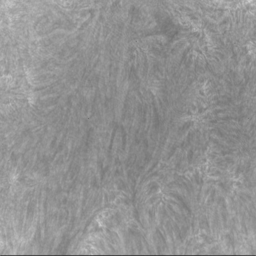

In [8]:
visualize_dataset(data_labelled['filaments'], step=1, end=48)

In [ ]:
save_img(data_labelled['filaments'][1200], '02')

In [10]:
fil_list = data_labelled['filaments'][:5]
flare_list = data_labelled['flares'][:5]
prom_list = data_labelled['prominences'][:5]
quiet_list = data_labelled['quiet'][:5]
spot_list = data_labelled['sunspots'][:5]

In [15]:
save_subsequent_imgs(spot_list)

In [ ]:
fits_path = 'example_data\\FG20111008_111533.0.fits.gz'

tmp = fits.getdata(fits_path)#.astype(np.float64)
#tmp = resize(tmp,(256,256),anti_aliasing=True)
#tmp = tmp.reshape(1,256,256)

im = Image.fromarray(tmp)
#im.save(filename)
#im.show()
#display(im)

new_fits = fits.open(fits_path)
new_fits.info()
new_fits[0].header
#im2 = Image.fromarray(new_fits[0])
#im2.show()